In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
!pip install openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.1/372.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 25.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 8.8 MB/s eta 0:00:00


In [3]:
!rm -rf mmsegmentation
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 14797, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (293/293), done.
remote: Total 14797 (delta 133), reused 218 (delta 84), pack-reused 14413
Receiving objects: 100% (14797/14797), 20.13 MiB | 36.82 MiB/s, done.
Resolving deltas: 100% (10436/10436), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Check Pytorch installation
import torch, torchvision

# Check MMSegmentation installation
import mmseg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [6]:
!mim download mmsegmentation --config segformer_mit-b0_8xb1-160k_cityscapes-1024x1024 --dest .

processing segformer_mit-b0_8xb1-160k_cityscapes-1024x1024...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MiB 18.1 MB/s eta 0:00:00
Successfully downloaded segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth to /content/mmsegmentation
Successfully dumped segformer_mit-b0_8xb1-160k_cityscapes-1024x1024.py to /content/mmsegmentation


In [7]:
from mmseg.apis import inference_model, init_model, show_result_pyplot
config_file = '/content/mmsegmentation/segformer_mit-b0_8xb1-160k_cityscapes-1024x1024.py'
checkpoint_file = '/content/mmsegmentation/segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth'

In [8]:
# build the model from a config file and a checkpoint file
model = init_model(config_file, checkpoint_file, device='cuda:0')

/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /content/mmsegmentation/segformer_mit-b0_8x1_1024x1024_160k_cityscapes_20211208_101857-e7f88502.pth


In [9]:
!mkdir -p /data/sets/nuimages  # Make the directory to store the nuImages dataset in.

!wget https://www.nuscenes.org/data/nuimages-v1.0-mini.tgz  # Download the nuImages mini split.

!tar -xf nuimages-v1.0-mini.tgz -C /data/sets/nuimages  # Uncompress the nuImages mini split.

--2023-04-28 18:54:24--  https://www.nuscenes.org/data/nuimages-v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 13.249.85.108, 13.249.85.65, 13.249.85.99, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|13.249.85.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117929607 (112M) [application/x-tar]
Saving to: ‘nuimages-v1.0-mini.tgz’

nuimages-v1.0-mini. 100%[===================>] 112.47M  38.0MB/s    in 3.0s    

2023-04-28 18:54:27 (38.0 MB/s) - ‘nuimages-v1.0-mini.tgz’ saved [117929607/117929607]



In [10]:
from keras.models import load_model

bev_folder = '/content/drive/MyDrive/Autonomous Driving/bev_generation_mapping/'
model_bev = load_model(bev_folder + 'Saved Models/model-14-0.93380.hdf5', compile=False)

In [12]:
model_pt = torch.load("/content/drive/MyDrive/Autonomous Driving/bev_classifier/weights_bev.pth")

In [20]:
def getLines(img):

    # Define the color ranges for each color of interest for creating masks.
    COLOR1_RANGE = [(30, 0, 0), (255, 50, 50)]  # Blue in BGR, [(low), (high)].
    COLOR2_RANGE = [(0, 30, 0), (50, 255, 50)] 

    # Create masks:
    color1_mask = cv2.inRange(img, COLOR1_RANGE[0], COLOR1_RANGE[1])
    color2_mask = cv2.inRange(img, COLOR2_RANGE[0], COLOR2_RANGE[1])

    # Adjust according to your adjacency requirement.
    kernel = np.ones((3, 3), dtype=np.uint8)

    # Dilating masks to expand boundary.
    color1_mask = cv2.dilate(color1_mask, kernel, iterations=1)
    color2_mask = cv2.dilate(color2_mask, kernel, iterations=1)

    # Required points now will have both color's mask val as 255.
    common = cv2.bitwise_and(color1_mask, color2_mask)
    return common

1/1 [==============================] - 0s 19ms/step


[0, 1, 0, 0, 0]


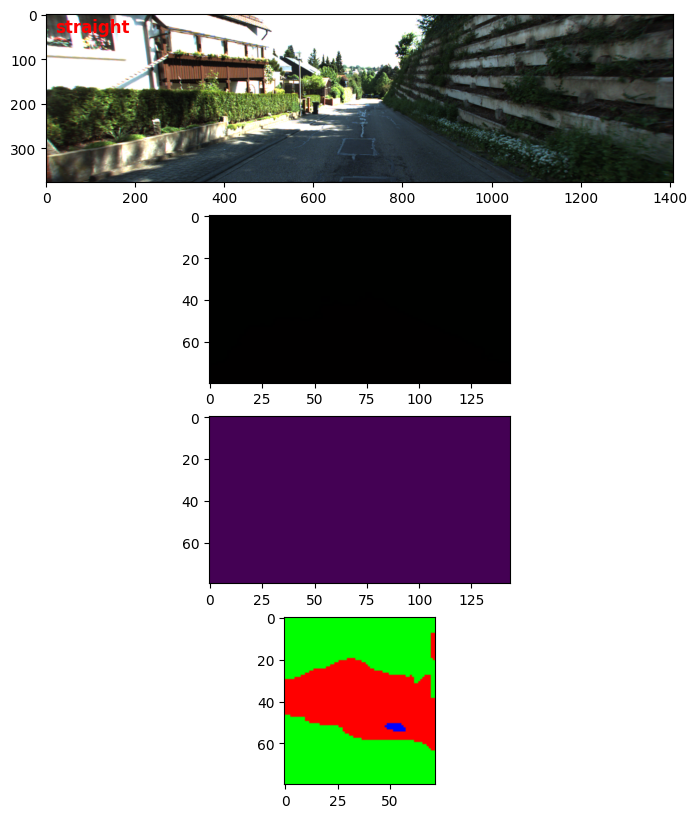

In [22]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import time
import glob

predictions = [0, 0, 0, 0, 0]
# for filename in glob.glob("/content/drive/MyDrive/Autonomous Driving/front_classifier/data/k360_segformer/train/*/*.png"):
for filename in glob.glob("/content/drive/MyDrive/mobilenet/k360/test/0/*.png"):
  f, axarr = plt.subplots(4, figsize=(10,10))
  t0 = time.time()
  
  img = Image.open(filename)
  img = np.array(img)
  axarr[0].imshow(img)

  result = inference_model(model, img)
  img = show_result_pyplot(model, img, result, show=False, opacity=1.0)
  RED = (1, 0, 0)
  GREEN = (0, 1, 0)
  BLUE = (0, 0, 1)

  red, green, blue = img.T # Temporarily unpack the bands for readability

  # Pipeline
  car_area = (red == 0) & (green == 0) & (blue == 142)
  truck_area = (red == 0) & (green == 0) & (blue == 70)
  bus_area = (red == 0) & (green == 60) & (blue == 100)
  caravan_area = (red == 0) & (green == 0) & (blue == 90)
  trailer_area = (red == 0) & (green == 0) & (blue == 110)
  train_area = (red == 0) & (green == 80) & (blue == 100)
  motorcycle_area = (red == 0) & (green == 0) & (blue == 230)
  bicycle_area = (red == 119) & (green == 11) & (blue == 32)
  road_area = (red == 128) & (green == 64) & (blue == 128)
  pedestrian_area = (red == 220) & (green == 20) & (blue == 60)
  img[:,:,:3] = GREEN
  img[:,:,:3][car_area.T] = BLUE # Transpose back needed
  img[:,:,:3][truck_area.T] = BLUE # Transpose back needed
  img[:,:,:3][bus_area.T] = BLUE # Transpose back needed
  img[:,:,:3][caravan_area.T] = BLUE # Transpose back needed
  img[:,:,:3][trailer_area.T] = BLUE # Transpose back needed
  img[:,:,:3][train_area.T] = BLUE # Transpose back needed
  img[:,:,:3][motorcycle_area.T] = BLUE # Transpose back needed
  img[:,:,:3][bicycle_area.T] = BLUE # Transpose back needed
  img[:,:,:3][pedestrian_area.T] = BLUE
  img[:,:,:3][road_area.T] = RED # Transpose back needed
  
  # Generate
  # road_area = (red == 255) & (green == 0) & (blue == 0)
  # obstacles_area = (red == 0) & (green == 0) & (blue == 255)
  # nonroad_area = (red == 0) & (green == 255) & (blue == 0)
  # img[:,:,:3][road_area.T] = RED # Transpose back needed
  # img[:,:,:3][obstacles_area.T] = BLUE # Transpose back needed
  # img[:,:,:3][nonroad_area.T] = GREEN # Transpose back needed

  # plt.imshow(img)
  img = Image.fromarray(img).resize((328, 80))
  img = img.crop((92, 0, 236, 80))
  img = np.array(img)
  lines = getLines(img)
  axarr[1].imshow(img)
  axarr[2].imshow(lines)

  pred = model_bev.predict(np.array([img]))[0]
  pred = np.argmax(pred, axis=-1)
  rgb = np.empty([pred.shape[0], pred.shape[1], 3])
  for i in range(3):
      rgb[:, :, i] = np.where(np.isin(pred, i), 255, 0)
  axarr[3].imshow(rgb)
  img = Image.fromarray(rgb.astype('uint8'))

  # Save file
  # filename = filename.replace("/front_classifier/data/k360_segformer/", "/bev_classifier/data/bev/")
  # img.save(filename)
  
  t1 = time.time()

  # # 0=straight, 1=left T, 2=right T, 3=left/right T, 4=cross
  class_names = ['fourway', 'straight', 'threeway_left', 'threeway_right', 'threeway_t']
  data_transforms = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  img = data_transforms(img).unsqueeze(0)
  img = img.to(device)

  output = model_pt(img)
  pred = output.cpu().data.numpy().argmax()
  t2 = time.time()
  axarr[0].text(20, 40, class_names[pred], color='red', fontsize='large', fontweight='bold')

  predictions[pred] += 1
  break

print(predictions)

In [ ]:
  # 